In [4]:
%load_ext autoreload
%autoreload 2
import os 
import matplotlib.pyplot as plt

from pydrifters import driftiter
import pickle
import numpy as np
driftiter.drift_iter
import pydrifters.globetools as gt
drift_file=os.environ['DRIFTFILE']
grid = [-82,-9,18,60] 
drift_gen = driftiter.generator(drift_file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
sample_stations = np.array([[-79.5395,  29.6394],
       [-72.9289,  36.4121],
       [-70.0377,  39.2305],
       [-71.3093,  34.6712],
       [-66.5435,  33.061 ],
       [-28.935 ,  36.1375]])

In [ ]:
%%timeit
for i in drift_gen(drogue=None,variables=['position', 'drogue', 'datetime'], drop_na=False):
    pass

In [ ]:
from pydrifters.grid.h3_story import get_story
from pydrifters.globetools import random_ll_rot
q= random_ll_rot()
list_of_stories= get_story(drift_gen(drogue=True, variables=['position', 'drogue', 'datetime'],drop_na=False,lon_lat_transform=q.arr_call), day_cut_off=2, silent=False, )
import pydrifters.grid.transition as tt
trans_network = tt.make_h3_transition(list_of_stories)

import pydrifters.grid as pydg
import pydrifters.grid.gpd_vis as gvis
import geopandas as gpd
from h3 import h3
h3_gpd = gvis.network_to_multipolygon_df(trans_network)

In [ ]:
full_tt, full_path = tt.network_to_pairwise_diss_arr(trans_network, sample_stations, day_cut_off=2, path = True)
import random
from numba import prange, njit, jit

@jit(parallel=True, forceobj=True)
def bootstrap_distance(list_of_stories, sample_stations, n_boot=5):
    arr_list = []
    path_list = []
    for i in range(n_boot):
        len_of_samples = len(list_of_stories)
        bootstrap_inds = np.random.randint(0,len_of_samples,size=len_of_samples)
        bootstrapped_stories = [list_of_stories[i] for i in bootstrap_inds]
        boot_network = tt.make_h3_transition(bootstrapped_stories)
        arr, path = tt.network_to_pairwise_diss_arr(boot_network, sample_stations, day_cut_off=2, path=True)
        arr_list.append(arr)
        path_list.append(path)
    return(arr_list, path_list)

In [ ]:
h_inds =[ h3.geo_to_h3(lng=i[0], lat=i[1], res=3) for i in sample_stations]
h_inds

In [ ]:
import networkx as nx
cc = list(nx.weakly_connected_components(trans_network))
ng = trans_network.subgraph(cc[0])

In [ ]:
ng.edges['83d0e2fffffffff','83d0e2fffffffff']

In [ ]:
%timeit dict(nx.floyd_warshall(ng, weight='neg_log_prob'))
%timeit dict(nx.all_pairs_dijkstra(ng, weight='neg_log_prob'))

In [ ]:
import os 
import matplotlib.pyplot as plt

from pydrifters import driftiter
import numpy as np
driftiter.drift_iter
import pydrifters.globetools as gt

import pydrifters.grid.transition as tt
from pydrifters.grid.h3_story import get_story
from pydrifters.globetools import random_ll_rot
import pydrifters.grid as pydg
import pydrifters.grid.gpd_vis as gvis
import geopandas as gpd
from h3 import h3
import pickle
drift_file=os.environ['DRIFTFILE']
grid = [-82,-9,18,60] 
drift_gen = driftiter.generator_lambda(drift_file, grid=grid)
n_boot =2
n_rot =2
sample_stations = np.array([[-79.5395,  29.6394],
       [-72.9289,  36.4121],
       [-70.0377,  39.2305],
       [-71.3093,  34.6712],
       [-66.5435,  33.061 ],
       [-28.935 ,  36.1375]])
np.random.seed(10)
l = [random_ll_rot() for i in range(n_rot)]


import random
from numba import prange, njit, jit

def bootstrap_distance(list_of_stories, sample_stations, n_boot=5):
    arr_list = []
    path_list = []
    for i in range(n_boot):
        len_of_samples = len(list_of_stories)
        bootstrap_inds = np.random.randint(0,len_of_samples,size=len_of_samples)
        bootstrapped_stories = [list_of_stories[i] for i in bootstrap_inds]
        boot_network = tt.make_h3_transition(bootstrapped_stories)
        arr, path = tt.network_to_pairwise_diss_arr(boot_network, sample_stations, day_cut_off=2, path=True)
        arr_list.append(arr)
        path_list.append(path)
    return(arr_list, path_list)

def boot_rotation(rot, n_boot):
    list_of_stories= get_story(drift_gen(drogue=True, variables=['position', 'drogue', 'datetime'],drop_na=False,lon_lat_transform=rot.arr_call), day_cut_off=2, silent=False )
    full_trans_network = tt.make_h3_transition(list_of_stories)
    full_tt, full_path = tt.network_to_pairwise_diss_arr(full_trans_network, sample_stations, day_cut_off=2, path = True)
    arr_list_samples, path_list_samples = bootstrap_distance(list_of_stories, sample_stations,n_boot)
    return {'full_tt':full_tt, 'full_path':full_path, 'boot_samples':arr_list_samples, 'boot_path':path_list_samples, 'rot':rot}
res =[]
for rot in l:
    res.append(boot_rotation(rot,n_boot))
pickle.dump( res, open( "save_twist_n_shout.p", "wb" ) )


In [ ]:
boot_rotation(rot,n_boot)

In [70]:
from pydrifters.globetools import random_ll_rot
import numpy as np 
orig = np.array([1,0,0])
orig = orig/np.linalg.norm(orig)
rot = random_ll_rot()

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [72]:
xi =[]
yi =[]
zi =[]
for i in range(100):
    rot=random_ll_rot()
    p = rot.rot.apply(orig)
    x_rot, y_rot, z_rot = p
    xi.append(x_rot)
    yi.append(y_rot)
    zi.append(z_rot)

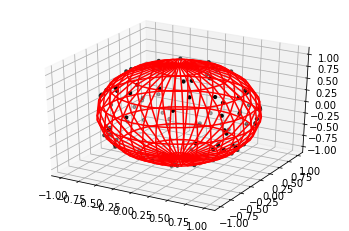

In [73]:
phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 20)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))



fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
ax.plot_wireframe(x, y, z, color='r', rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=10, c='black', zorder=10)

In [69]:
np.mean(x)

-2.220446049250313e-18

In [47]:
np.mean(yi)

0.0022970304842679008

In [48]:
np.mean(xi)

0.0022822947965271735

In [49]:
np.mean(zi)

-0.78624833567294

## What do the rotations actually look like

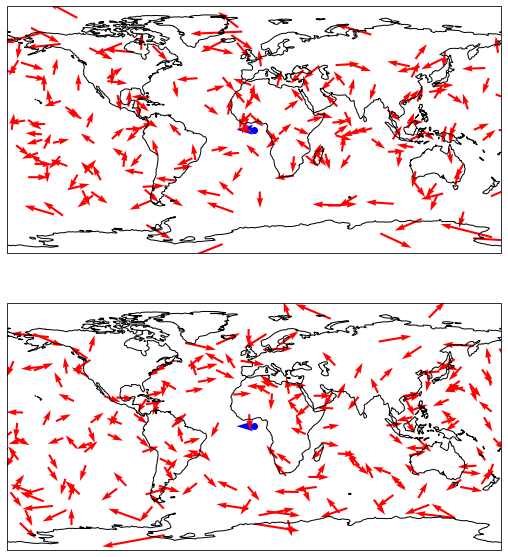

In [2]:
%load_ext autoreload
%autoreload 2
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from DriftMLP.rotations import random_ll_rot
coord1 = (0,0)
coord2 = (-1,0)


fig,(ax_quat, ax_arvo)= plt.subplots(2,1,
                    subplot_kw = {'projection':ccrs.PlateCarree()}, 
                     figsize=(10,10))

def rotations_plots(random_rots_list, ax):
    
    ax.plot(coord1[0], coord1[1], 'bo',transform = ax.projection)
    arrows_c1 = np.array([rot(*coord1) for rot in random_rots_list])
    arrows_c2 = np.array([rot(*coord2) for rot in random_rots_list])
    kwargs_for_plot = {'scale':30,
                      'width':0.01,
                      'color':'blue',
                      'headwidth':3}
    ax.quiver(x=np.array(coord2[0]).reshape(1,1), 
              y=np.array(coord2[1]).reshape(1,1),
              u = np.array(coord2[0]- coord1[0]).reshape(1,1),
              v=np.array(coord2[1]- coord1[1]).reshape(1,1),
                transform = ccrs.PlateCarree(), 
              **kwargs_for_plot)
    uv_arr = arrows_c2-arrows_c1
    ax.quiver(x=arrows_c2[:,0], y=arrows_c2[:,1],
              u = uv_arr[:,0], v=uv_arr[:,1], color ='red',
              transform = ccrs.PlateCarree(), scale=30)
    #fig.tight_layout()
    #ax.set_title('Random Roations on the Sphere')
    #fig.savefig('Images/RandomRotations.pdf')
    ax.set_global()
    ax.coastlines()
random_rots = [random_ll_rot(method='quat') for i in range(200)]
rotations_plots(random_rots, ax_quat)
random_rots = [random_ll_rot(method='arvo') for i in range(200)]
rotations_plots(random_rots, ax_arvo)
display(fig)

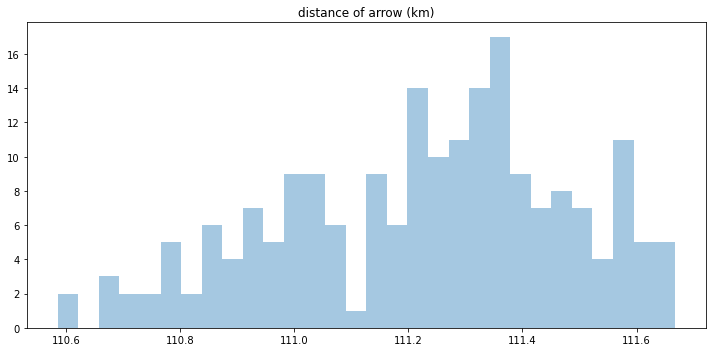

In [6]:
from cartopy import geodesic
import seaborn as sns
glb = geodesic.Geodesic()
c1_rots = np.array([rot(*coord1) for rot in random_rots])
c2_rots = np.array([rot(*coord2) for rot in random_rots])
ex= np.asarray(glb.inverse(np.array(coord1), np.array(coord2)))
all_dists = np.asarray(glb.inverse(c1_rots, c2_rots))
fig, axes = plt.subplots(1,1, figsize=[10,5])
sns.distplot(all_dists[:,0]*1e-3, ax =axes,kde=False, bins=30)
axes.set_title('distance of arrow (km)')

fig.tight_layout()
display(fig)

array([[ 2.22044605e-16, -1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  2.22044605e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

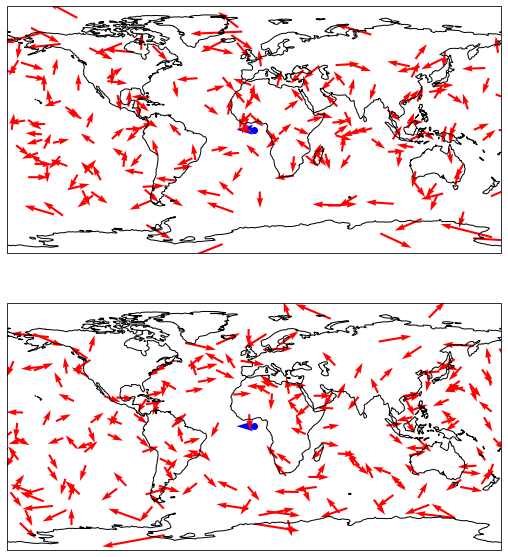

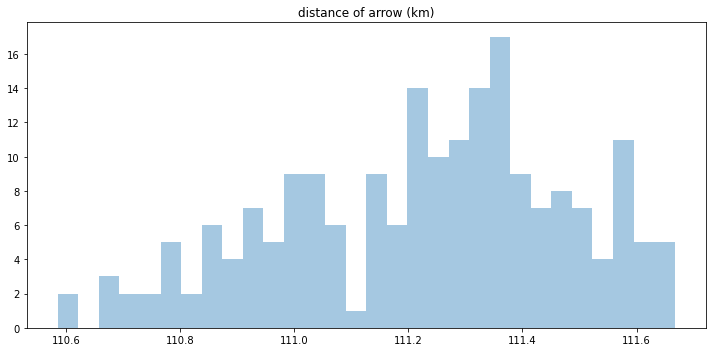

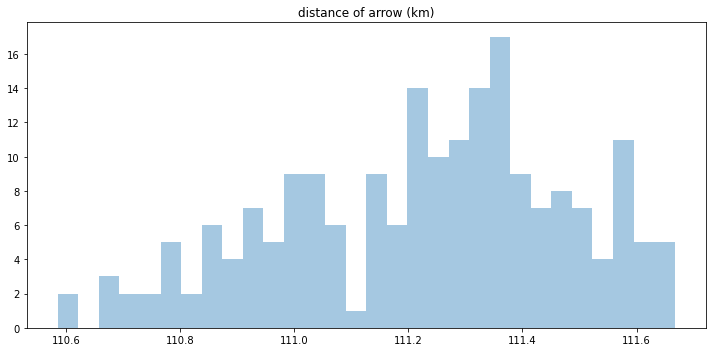

In [7]:
from scipy.spatial.transform import Rotation as R
rot = R.from_euler('xyz', [0,0,np.pi/2])
rot.as_matrix()

<ipython-input-13-523505c1cf29>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,4, figsize=[10,4])
<ipython-input-13-523505c1cf29>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig3 = plt.figure()


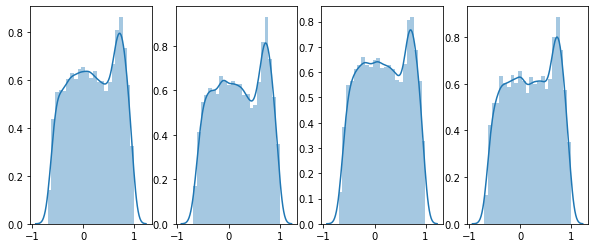

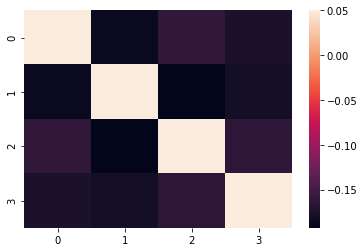

<ipython-input-13-523505c1cf29>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, axes2 = plt.subplots(1,3, figsize=[10,4])
<ipython-input-13-523505c1cf29>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig4= plt.figure()


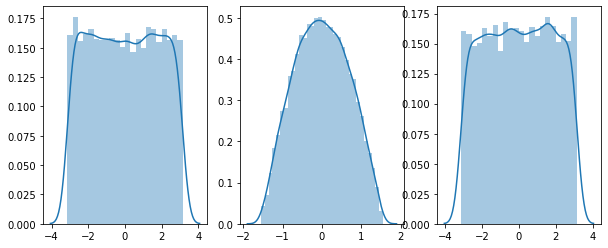

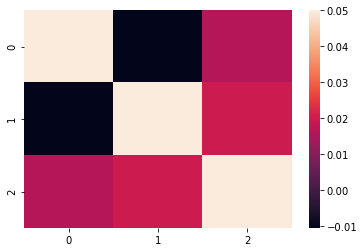

In [13]:
random_rots = [random_ll_rot(method='arvo') for i in range(10000)]
qq = np.array([rot.rot.as_quat() for rot in random_rots])
fig, axes = plt.subplots(1,4, figsize=[10,4])
for i in range(4):
    sns.distplot(qq[:,i], ax = axes[i])
fig
fig3 = plt.figure()
sns.heatmap(np.corrcoef(qq, rowvar=False), vmax=0.05)
display(fig)
display(fig3)

fig2, axes2 = plt.subplots(1,3, figsize=[10,4])
qq = np.array([rot.rot.as_euler('xyz') for rot in random_rots])
for i in range(3):
    sns.distplot(qq[:,i], ax = axes2[i])
fig4= plt.figure()
sns.heatmap(np.corrcoef(qq, rowvar=False), vmax=0.05)

display(fig2)
display(fig4)

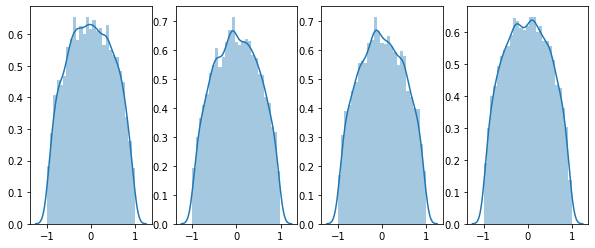

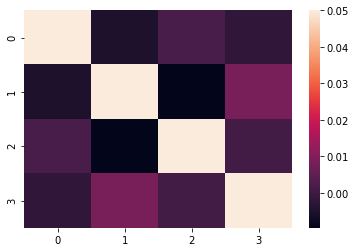

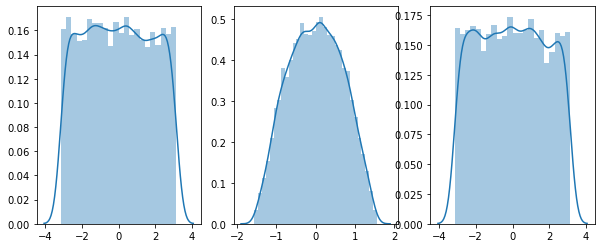

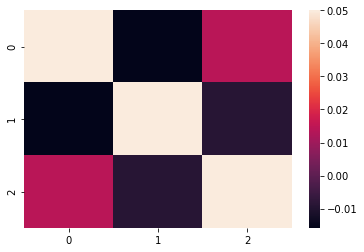

In [12]:
random_rots = [random_ll_rot(method='quat') for i in range(10000)]
qq = np.array([rot.rot.as_quat() for rot in random_rots])
fig, axes = plt.subplots(1,4, figsize=[10,4])
for i in range(4):
    sns.distplot(qq[:,i], ax = axes[i])
fig
fig3 = plt.figure()
sns.heatmap(np.corrcoef(qq, rowvar=False), vmax=0.05)
display(fig)
display(fig3)

fig2, axes2 = plt.subplots(1,3, figsize=[10,4])
qq = np.array([rot.rot.as_euler('xyz') for rot in random_rots])
for i in range(3):
    sns.distplot(qq[:,i], ax = axes2[i])
fig4= plt.figure()
sns.heatmap(np.corrcoef(qq, rowvar=False), vmax=0.05)

display(fig2)
display(fig4)

array([[ 1.        , -0.01637039,  0.01160467],
       [-0.01637039,  1.        ,  0.00885801],
       [ 0.01160467,  0.00885801,  1.        ]])

In [19]:
help(ax.set_extent)

Help on method set_extent in module cartopy.mpl.geoaxes:

set_extent(extents, crs=None) method of cartopy.mpl.geoaxes.GeoAxesSubplot instance
    Set the extent (x0, x1, y0, y1) of the map in the given
    coordinate system.
    
    If no crs is given, the extents' coordinate system will be assumed
    to be the Geodetic version of this axes' projection.
    
    Parameters
    ----------
    extents
        Tuple of floats representing the required extent (x0, x1, y0, y1).

